In [1]:
import numpy as np
import random
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import dates
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from lmfit import Minimizer, Parameters, Parameter, report_fit, printfuncs, conf_interval
from statsmodels.tsa.arima_model import ARIMA

# step 0: data importation #

In [2]:
csv_url="https://raw.githubusercontent.com/ADelau/proj0016-epidemic-data/main/data.csv"
data = pd.read_csv(csv_url)

In [3]:
subdata=data[40:]

In [4]:
data2=data.rolling(14, min_periods=1, center=True).mean()
data2

,Day,num_positive,num_tested,num_hospitalised,num_cumulative_hospitalizations,num_critical,num_fatalities
0,4.0,7.285714,9.571429,1.714286,1.714286,0.000000,0.000000
1,4.5,8.625000,11.125000,2.000000,2.000000,0.000000,0.000000
2,5.0,9.444444,12.444444,2.333333,2.444444,0.000000,0.000000
3,5.5,10.100000,13.300000,2.800000,3.000000,0.000000,0.000000
4,6.0,12.000000,15.454545,3.181818,3.545455,0.000000,0.000000
...,...,...,...,...,...,...,...
66,65.5,1438.250000,1788.000000,517.166667,1107.500000,52.500000,32.833333
67,66.0,1481.818182,1844.000000,535.363636,1145.545455,53.181818,34.000000
68,66.5,1530.900000,1907.100000,555.600000,1186.100000,54.100000,35.200000
69,67.0,1581.333333,1969.444444,576.888889,1229.111111,55.333333,36.444444


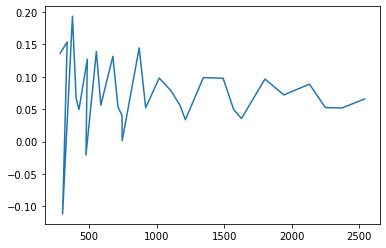

In [5]:
plt.plot(subdata['num_tested'],subdata['num_tested'].diff()/subdata['num_tested'])

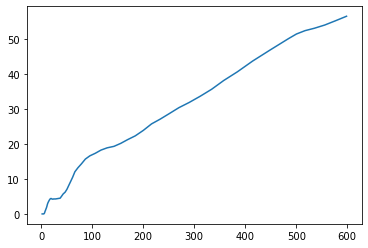

In [6]:
plt.plot(data2['num_hospitalised'],data2['num_critical'])

In [7]:
test2=data['num_tested']
data2=data.rolling(7, min_periods=1, center=True).mean()

# step 1: setting up the model #

## step 1.1: writing the ode system ##

In [8]:
def deriv(y, t, N, ps):
    S,E,I,C,R,H,ICU,D = y
    
    beta_SE = ps['beta_SE'].value
    gamma_ER = ps['gamma_ER'].value
    fraction_symptomatic = ps['fraction_symptomatic'].value
    days_EtoI=ps['days_EtoI'].value
    days_ItoH=ps['days_ItoH'].value
    days_ItoR=ps['days_ItoR'].value
    days_HtoR=ps['days_HtoR'].value
    days_HtoICU=ps['days_HtoICU'].value
    days_ICUtoD=ps['days_ICUtoD'].value
    days_ICUtoH=ps['days_ICUtoH'].value
    #tau=ps['tau'].value
    #tau_period=ps['tau_period'].value
        
    
    #beta = beta_i*(1.1-tau*t) idée de faire régresser beta
    
    
    dSdt = -beta_SE*(S*(I+C))/(N-D)
    dEdt = beta_SE*(S*(I+C))/(N-D)-gamma_ER*E
    dIdt = (fraction_symptomatic)*E/days_EtoI-I*(1/days_ItoH+1/days_ItoR)
    dCdt = (1-fraction_symptomatic)*E/days_EtoI-C/days_ItoR
    dRdt = (C+I)/days_ItoR+H/days_HtoR
    dHdt = I/days_ItoH*I+ICU/days_ICUtoH-H*(1/days_HtoICU+1/days_HtoR)
    dICUdt = H/days_HtoICU-ICU*(1/days_ICUtoD+1/days_ICUtoH)
    dDdt = ICU/days_ICUtoD
    
    return dSdt, dEdt, dIdt, dCdt, dRdt, dHdt, dICUdt, dDdt

## step 1.2: writing the parameters values and guesses ##


In [9]:
# the lmfit module uises an orderd dict structure
# to store the parameters to be optimized
# https://lmfit.github.io/lmfit-py/parameters.html

params = Parameters()
params.add('beta_SE', value=0.15, min=1, max=10)
params.add('gamma_ER', value= 0.05, min=0.1, max=2)
params.add('fraction_symptomatic', value= 0.6, min=0.5, max=0.7)
params.add('days_EtoI', value= 3, min=1, max=5)
params.add('days_ItoH',value=5, min=1,max=20)
params.add('days_ItoR',value=10,min=1,max=50)
params.add('days_HtoR',value=12,min=1,max=100)
params.add('days_HtoICU',value=5,min=1,max=50)
params.add('days_ICUtoD',value=2,min=1,max=50)
params.add('days_ICUtoH',value=6,min=1,max=50)
params.add('E0',value=10,min=1,max=40)
params.add('I0',value=5,min=1,max=20)
params.add('C0',value=5,min=0,max=20)
params.add('OBS_Tr_EI_to_nbTest',value=0.25,min=0.05,max=1)
params.add('OBS_nbTest_to_nbpos',value=0.75,min=0.5,max=0.9)
# params.add('OBS_H_to_ICU',value=0.1,min=0.01,max=0.5) mistake??



## step 1.3 writing the solver ##

In [10]:

#this function solves the ode
#input: function deriv, initial compartiments y0, t, and N,ps as arguments??
#output: the ode solution
def odesol(y,t,N,ps):
    
    ts = np.linspace(0, t, t+1)
    result = odeint(deriv, y, ts, args=(N, ps))
    
    return result



In [11]:
params

name,value,initial value,min,max,vary
beta_SE,1.00000000,0.15,1.00000000,10.0000000,True
gamma_ER,0.10000000,0.05,0.10000000,2.00000000,True
fraction_symptomatic,0.60000000,0.6,0.50000000,0.70000000,True
days_EtoI,3.00000000,3,1.00000000,5.00000000,True
days_ItoH,5.00000000,5,1.00000000,20.0000000,True
days_ItoR,10.0000000,10,1.00000000,50.0000000,True
days_HtoR,12.0000000,12,1.00000000,100.000000,True
days_HtoICU,5.00000000,5,1.00000000,50.0000000,True
days_ICUtoD,2.00000000,2,1.00000000,50.0000000,True
days_ICUtoH,6.00000000,6,1.00000000,50.0000000,True


In [12]:
# this function generate the observation dataframe
def create_obsdf(model,ps,data):
    result=pd.DataFrame(columns=data.columns)
    result['Day']=data['Day']
    nb_trans_EI=ps['beta_SE']*(model['S']*(model['I']+model['C']))/(10**6-model['D'])
    result['num_tested']=ps['OBS_Tr_EI_to_nbTest'].value*nb_trans_EI
    result['num_positive']=ps['OBS_nbTest_to_nbpos'].value*result['num_tested']
    result['num_hospitalised']=model['H']
    result['num_cumulative_hospitalizations']=result['num_hospitalised'].diff().fillna(0).cumsum()
    result['num_critical']=model['ICU']
    result['num_fatalities']=model['D']
    return result
    

#test['num_tested']=params['OBS_Tr_EI_to_nbTest'].value*

# step 2: fitting the model #

## step 2.1: write objective function ##

In [13]:
#this function compute residuals,
#ie objective function to be minimized in the optimization function
def residual(ps, ts, data, N):
    E0=ps['E0'].value
    I0 = ps['I0'].value
    C0=ps['C0'].value
    S0=N-I0-E0-C0-1
    R0=0
    H0=1
    ICU0=0
    D0=0
    
    y0 = S0,E0,I0,C0,R0,H0,ICU0,D0
    
    model = pd.DataFrame(odesol(y0,ts,N,ps), columns=['S','E','I','C','R','H','ICU','D'])
    obs_df=create_obsdf(model,ps,data)
    component1=(obs_df['num_positive']-data['num_positive']).ravel()
    component2=(obs_df['num_hospitalised']-data['num_hospitalised']).ravel()
    component3=(obs_df['num_critical']-data['num_critical']).ravel()
    component4=(obs_df['num_fatalities']-data['num_fatalities']).ravel()
    # penalty function to think more about !!!
    return (component1+component2+component3+component4)

In [14]:
np.log(2)

0.6931471805599453

In [15]:
t = np.linspace(0, data.shape[0]-1, data.shape[0])
residual(params,data.shape[0] - 1,data, 1e6)

C:\Users\DimiP\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


array([ 1.87496063e+00,  3.19627125e+00,  8.97991033e+00,  3.37602296e+01,
        9.50361712e+01,  2.33267378e+02,  5.58920277e+02,  1.30477069e+03,
        3.08629570e+03,  7.26418953e+03,  1.70658517e+04,  4.01368307e+04,
        9.43508658e+04,  2.21947434e+05,  5.23078340e+05,  1.23889994e+06,
        2.97260109e+06,  7.40244713e+06,  7.52424228e+16, -7.60000000e+01,
       -7.00000000e+01, -7.90000000e+01, -7.50000000e+01, -8.50000000e+01,
       -8.00000000e+01, -1.06000000e+02, -1.03000000e+02, -1.04000000e+02,
       -1.05000000e+02, -1.14000000e+02, -1.34000000e+02, -1.57000000e+02,
       -1.37000000e+02,             nan, -1.66000000e+02, -1.82000000e+02,
                   nan, -2.31000000e+02, -2.66000000e+02, -2.73000000e+02,
       -2.82000000e+02, -3.21000000e+02, -3.70000000e+02, -3.38000000e+02,
       -4.04000000e+02, -4.38000000e+02, -4.74000000e+02, -5.36000000e+02,
       -5.60000000e+02, -6.36000000e+02, -6.95000000e+02, -7.79000000e+02,
       -8.35000000e+02,  

## step 2.2: write optimization command ##

In [67]:
mini = Minimizer(residual, params, [subdata,1e6,])
result = mini.minimize()
result

TypeError: residual() missing 1 required positional argument: 'N'

In [20]:

E0=result.params['E0'].value
I0 = result.params['I0'].value
C0=result.params['C0'].value
S0=1e6-I0-E0-C0-1
R0=0
H0=1
ICU0=0
D0=0

y0 = S0,E0,I0,C0,R0,H0,ICU0,D0

model = pd.DataFrame(odesol(y0,70,1e6,result.params), columns=['S','E','I','C','R','H','ICU','D'])
obs_df=create_obsdf(model,result.params,data)
obs_df.head(30)

NameError: name 'result' is not defined

In [21]:
plt.plot(result.residual,label='residu')
plt.plot(data['num_positive'],label='data')
plt.plot(obs_df['num_positive'],label='sim')
plt.legend()

NameError: name 'result' is not defined

In [22]:
R2 = 1 - sum(result.residual**2) / sum((data['num_positive'] - np.mean(data['num_positive']))**2)
R2

NameError: name 'result' is not defined

In [95]:
# confidence intervals
ci = conf_interval(mini, result)
printfuncs.report_ci(ci)

KeyboardInterrupt: 